# Discrepancy in Hemophilia A

## Loading and Cleaning the Data
first of all we will load our datasets and clean them.

## Loading the packages

In [ ]:
# Loading Packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint, shapiro
import seaborn as sns
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 200)


## Loading the datasets

### Loading the patients data

In [ ]:
patients_data = pd.read_excel("FVIII_discrepant_mutations.xlsx", sheet_name = "Unique_mutations")
patients_data.shape

In [ ]:
patients_data.head()

### Loading SNPs Traits

version 2 of traits of the SNPS

In [ ]:
# Loading the data 1- features 
att_v2 = pd.read_excel("FVIII_attributes_v2.xlsx", sheet_name = "FVIII_attributes")
att_v2.shape

In [ ]:
att_v2.head()

version 3 of traits of the SNPS

In [ ]:
attr_v3 = pd.read_csv("FVIII_mutation_predictive_features.csv", sep= '\t')
attr_v3.rename(columns={"HGVS_pos":"AA_HGVS"}, inplace=True)
attr_v3.shape

In [ ]:
patients_data_v2 = pd.merge(patients_data, att_v2, on = "AA_HGVS", how = "left")
patients_data_v2

In [ ]:
# Extract the original amino acid, position, and new amino acid from the AA_change column
patients_data_v2["original_AA"] = patients_data_v2["AA_change"].str.extract(r"\((\w{3})\d+\w{3}\)")
patients_data_v2["new_AA"] = patients_data_v2["AA_change"].str.extract(r"\(\w{3}\d+(\w{3})\)")

# Drop the AA_change column
patients_data_v2 = patients_data_v2.drop(columns = ["AA_change", "Domain"])
patients_data_v2

In [ ]:
# Define a dictionary to map three-letter codes to one-letter codes
aa_dict = {
    'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D', 'Cys': 'C',
    'Gln': 'Q', 'Glu': 'E', 'Gly': 'G', 'His': 'H', 'Ile': 'I',
    'Leu': 'L', 'Lys': 'K', 'Met': 'M', 'Phe': 'F', 'Pro': 'P',
    'Ser': 'S', 'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V'
}

# Use the map method to apply the mapping to the original_AA and new_AA columns
patients_data_v2['original_AA'] = patients_data_v2['original_AA'].map(aa_dict)
patients_data_v2['new_AA'] = patients_data_v2['new_AA'].map(aa_dict)

In [ ]:
patients_data_v2 = patients_data_v2.drop("Residue", axis=1)

In [ ]:
patients_data_v2.head()

In [ ]:
patients_data_v2.rename(columns={"original_AA":"WT_aa", "new_AA":"new_aa"}, inplace=True)

In [ ]:
patients_data_v2.head()

In [ ]:
patients_data_v3 = pd.merge(patients_data_v2, attr_v3, on=['AA_HGVS', 'WT_aa', 'new_aa'], how='outer')


In [ ]:
patients_data_v3

## Exploring the data  

In [ ]:
grouped_data = patients_data_v3['discrepancy'].value_counts()
fig, ax = plt.subplots()
ax.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%')
ax.set_title('Distribution of Discrepancies in the Dataset')
plt.show()

## Checking for missing values

In [ ]:
pd.isnull(patients_data_v3).sum()

In [ ]:
patients_data_v3 = patients_data_v3.dropna()

In [ ]:
pd.isnull(patients_data_v3).sum()

In [ ]:
print(patients_data_v3.dtypes)
shapiro(patients_data_v3['consurf_old'])

## Normalization 

In [ ]:
# columns_to_normalize = ['relSESA', 'consurf_old', 'dg', 'bt', 'cl', 'SIFT_score_0',
#                         'SIFT_score_3', 'Polyphen2_dScore', 'Polyphen2_Score1', 'Polyphen2_Score2',
#                         'Polyphen2_dVol', 'Polyphen2_dProp', 'Polyphen2_NormASA', 'Polyphen2_MinDJxn',
#                         'Polyphen2_IdPmax']

# for column in columns_to_normalize:
#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    
#     # Plot original distribution
#     sns.histplot(pat_attr[column], ax=axes[0])
#     axes[0].set_title(f"Distribution of {column}")
#     axes[0].set_xlabel(column)
#     axes[0].set_ylabel("Frequency")
    
#     # Plot log-transformed distribution
#     sns.histplot(np.log(pat_attr[column]), ax=axes[1])
#     axes[1].set_title(f"Log-transformed Distribution of {column}")
#     axes[1].set_xlabel(f"log({column})")
#     axes[1].set_ylabel("Frequency")
    
#     # Plot square root distribution
#     sns.histplot(np.sqrt(pat_attr[column]), ax=axes[2])
#     axes[2].set_title(f"Square Root Distribution of {column}")
#     axes[2].set_xlabel(f"sqrt({column})")
#     axes[2].set_ylabel("Frequency")
    
#     plt.show()

In [ ]:
# pat_attr[['relSESA_log', 'consurf_old_log', 'bt_log']] = np.log(pat_attr[['relSESA', 'consurf_old', 'bt']])
# pat_attr[['Polyphen2_NormASA_sqrt', 'Polyphen2_MinDJxn_sqrt', 'Polyphen2_IdPmax_sqrt']] = np.sqrt(pat_attr[['Polyphen2_NormASA', 'Polyphen2_MinDJxn', 'Polyphen2_IdPmax']])
# pat_attr = pat_attr.drop(columns=['relSESA', 'consurf_old', 'bt', 'Polyphen2_NormASA', 'Polyphen2_MinDJxn', 'Polyphen2_IdPmax'])


In [118]:
patients_data_v3.columns

Index(['AA_HGVS', 'domain', 'mild', 'moderate', 'severe', 'discrepancy',
       'relSESA', 'consurf_old', 'dg', 'bt', 'cl', 'auth', 'kcore', 'WT_aa',
       'new_aa', 'SIFT_score_0', 'SIFT_score_3', 'Polyphen2_dScore',
       'Polyphen2_Score1', 'Polyphen2_Score2', 'Polyphen2_dVol',
       'Polyphen2_dProp', 'Polyphen2_NormASA', 'Polyphen2_MinDJxn',
       'Polyphen2_IdPmax', 'Polyphen2_IdQmin'],
      dtype='object')

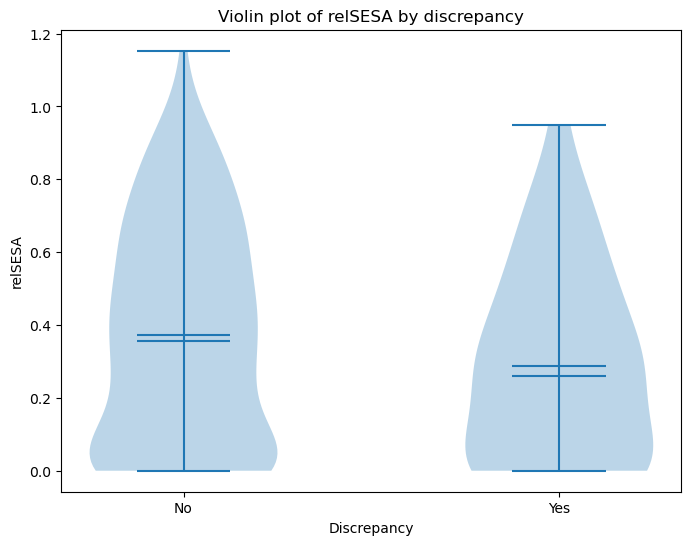

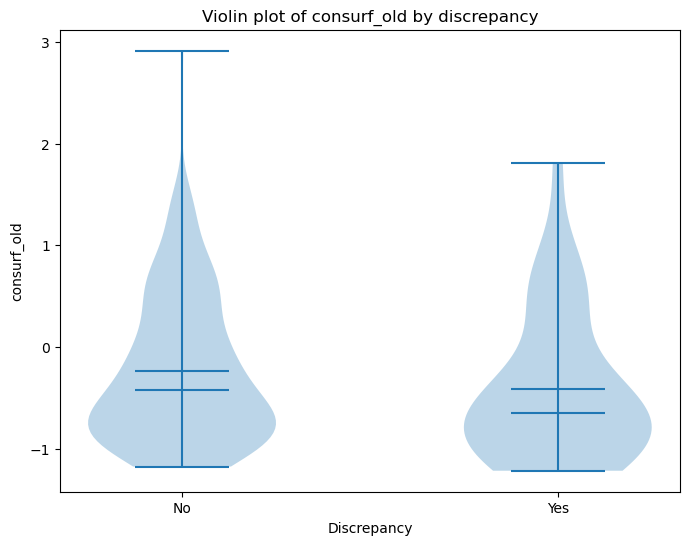

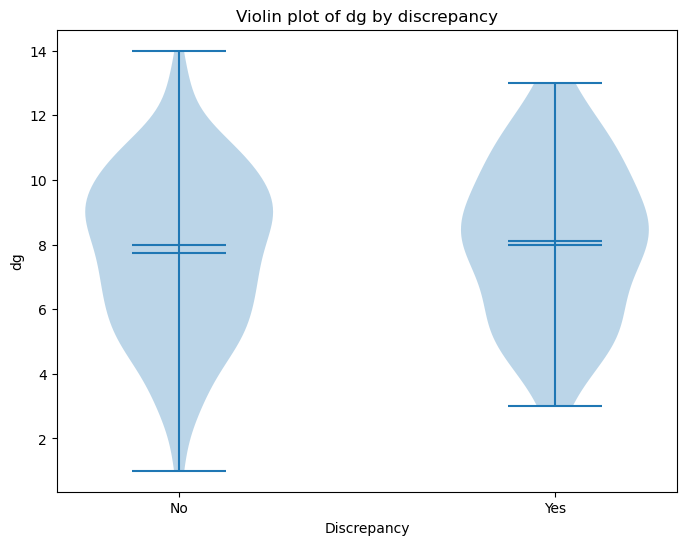

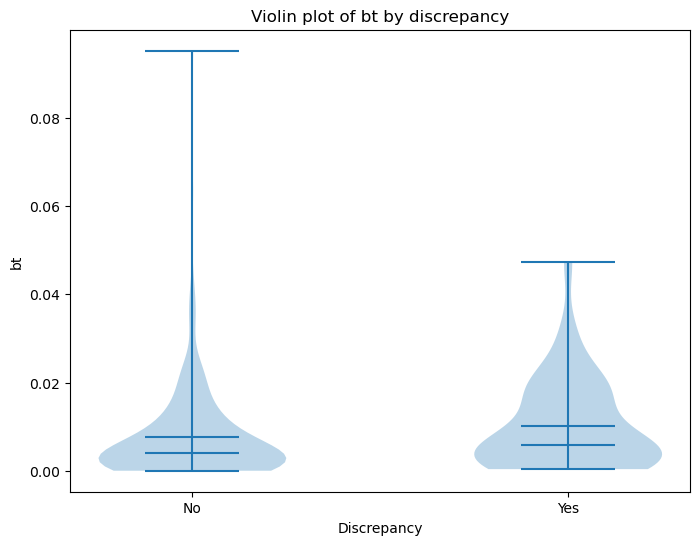

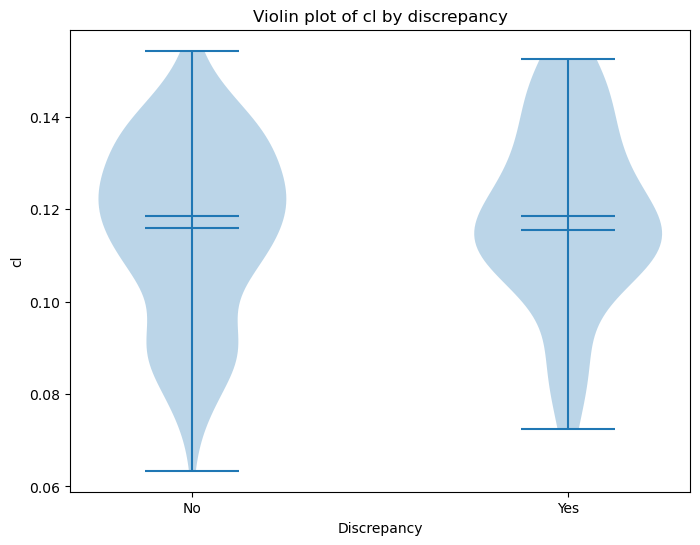

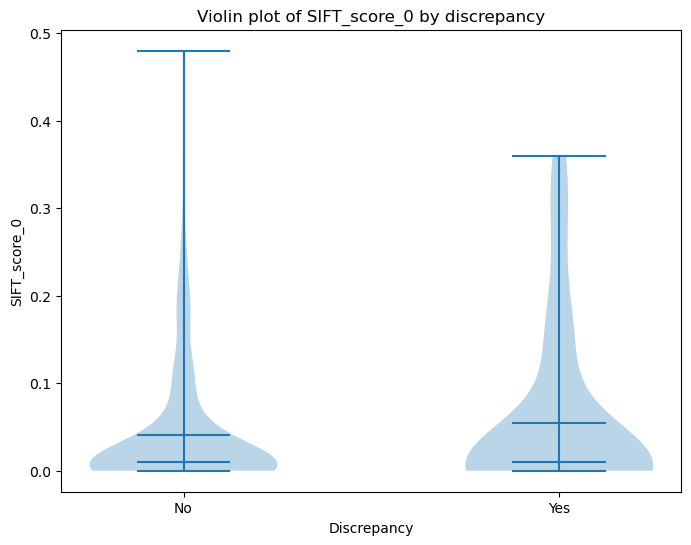

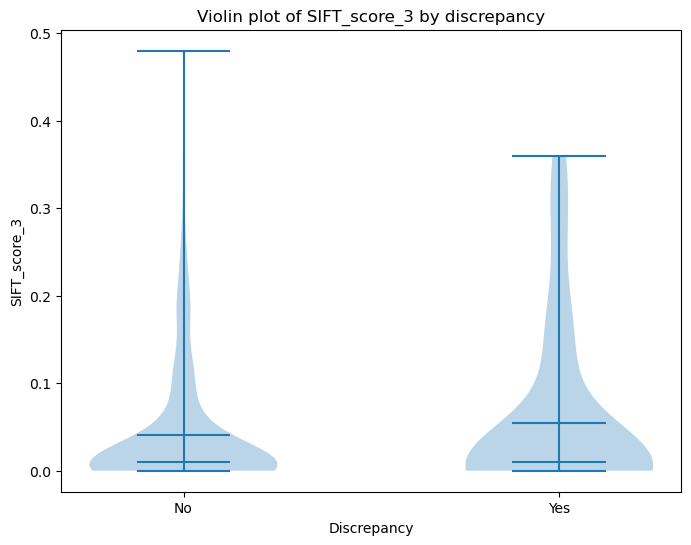

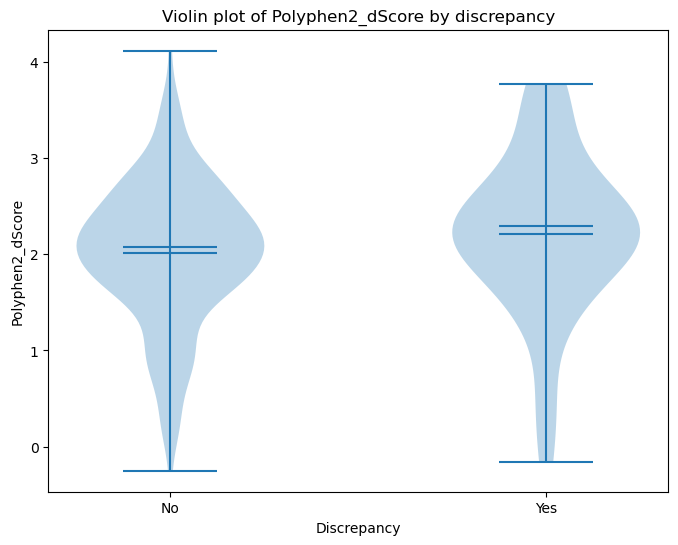

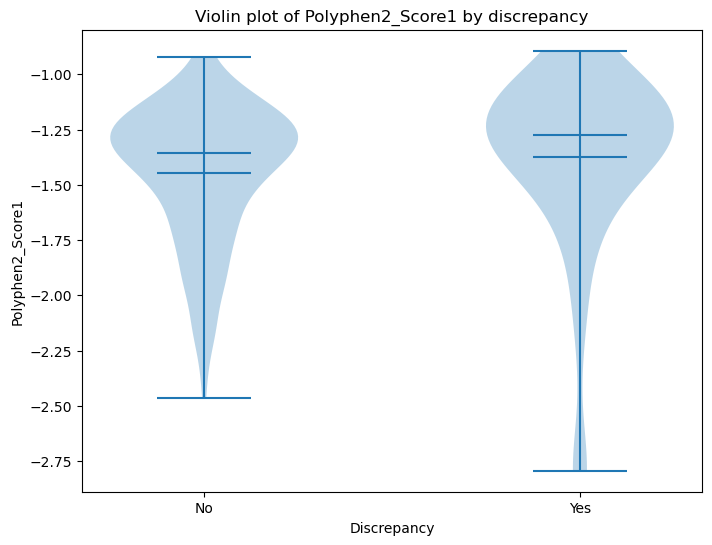

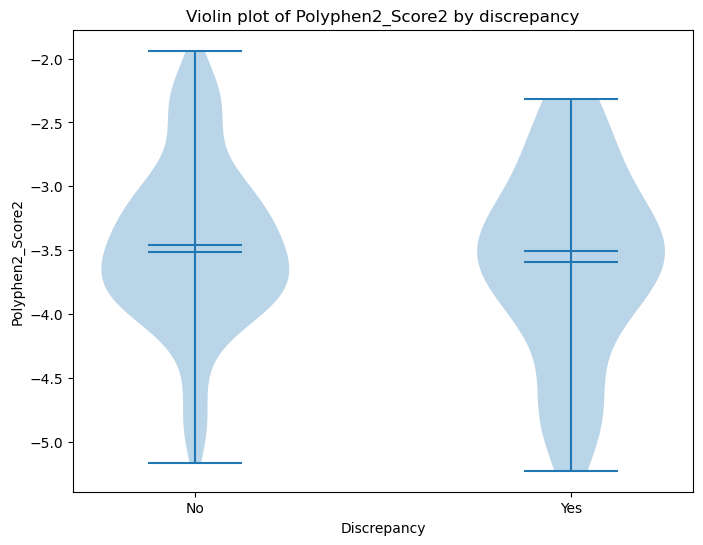

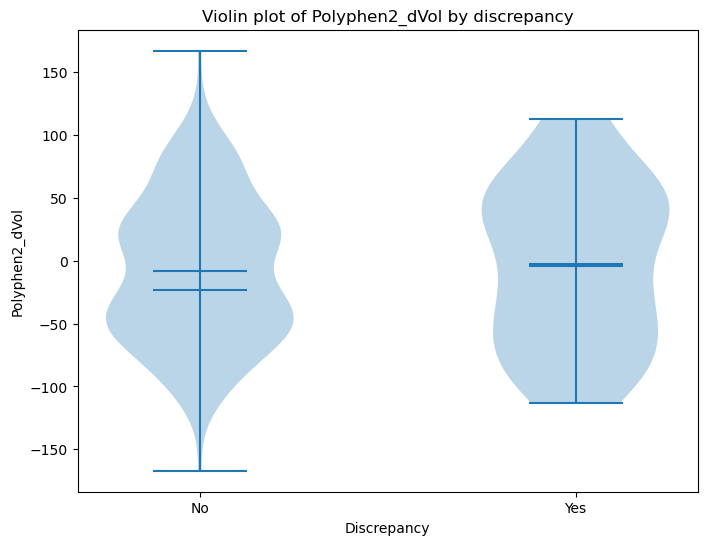

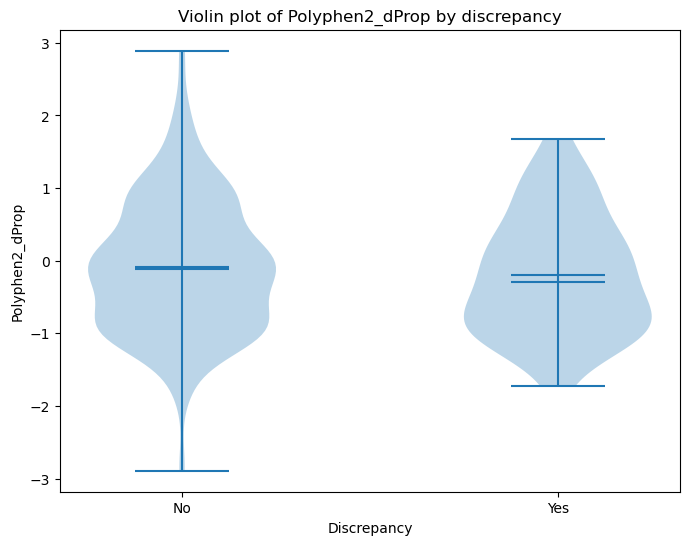

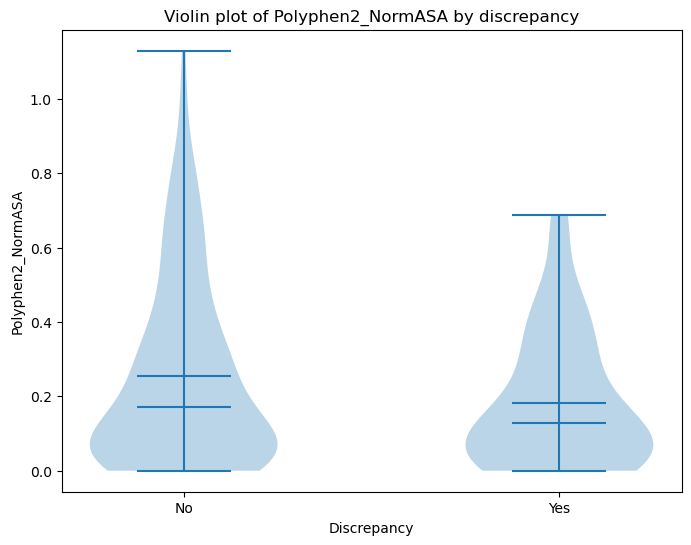

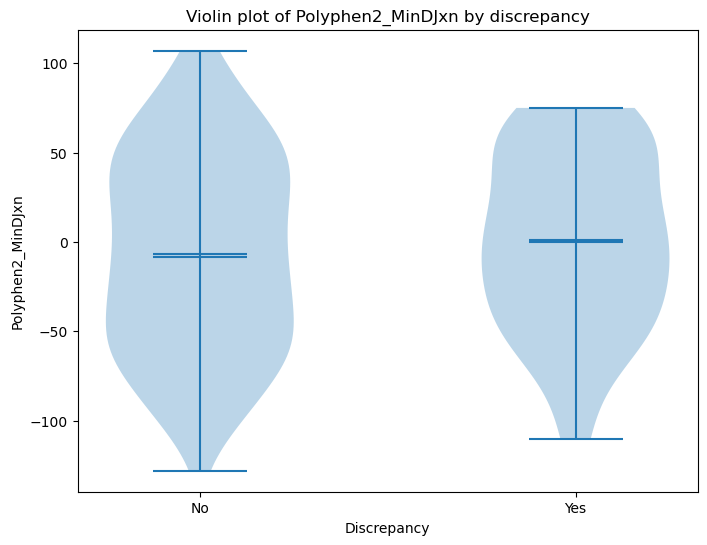

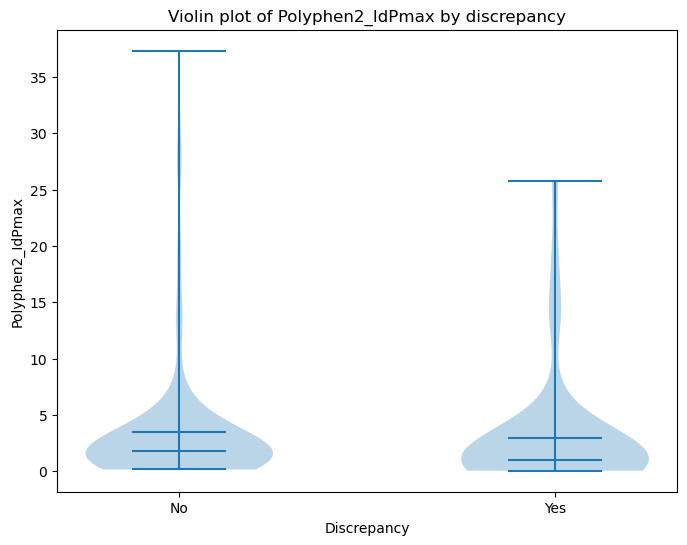

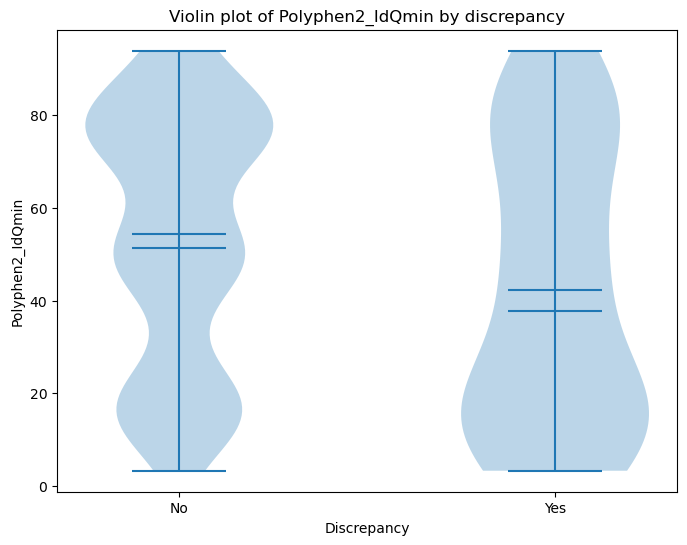

In [141]:

# create a list of numeric column names
col_name_list = ['relSESA', 'consurf_old', 'dg', 'bt', 'cl', 'SIFT_score_0', 'SIFT_score_3',
            'Polyphen2_dScore', 'Polyphen2_Score1', 'Polyphen2_Score2', 'Polyphen2_dVol',
            'Polyphen2_dProp', 'Polyphen2_NormASA', 'Polyphen2_MinDJxn', 'Polyphen2_IdPmax',
            'Polyphen2_IdQmin']

grouped = patients_data_v3.groupby('discrepancy')


for col in col_name_list:
    # create the violin plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.violinplot([group[col].dropna() for name, group in grouped], showmeans=True, showmedians=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_xlabel('Discrepancy')
    ax.set_ylabel(col)
    ax.set_title(f'Violin plot of {col} by discrepancy')
    plt.show()

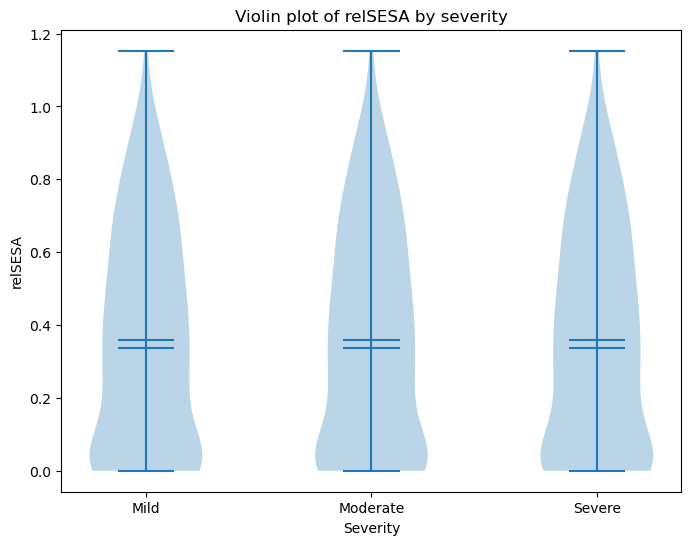

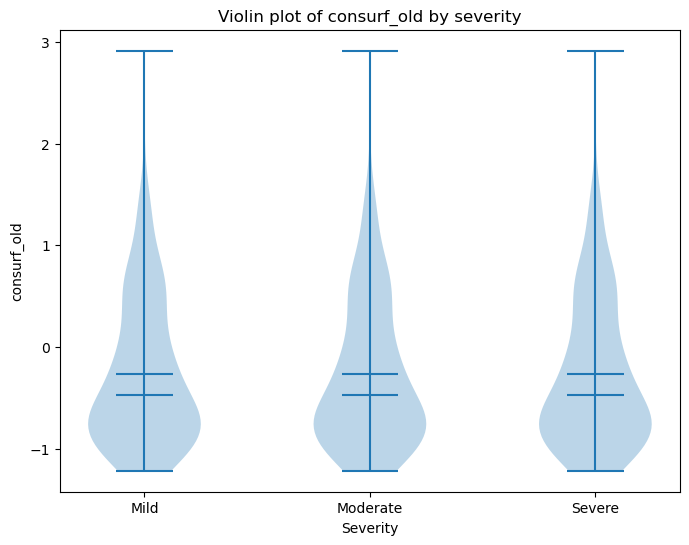

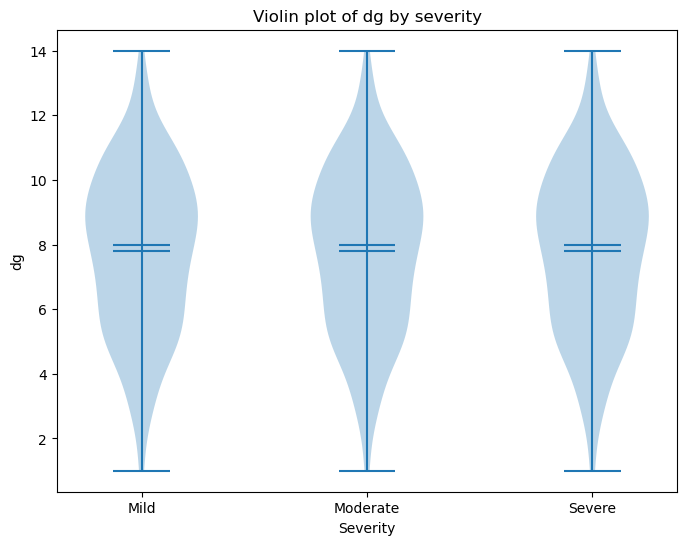

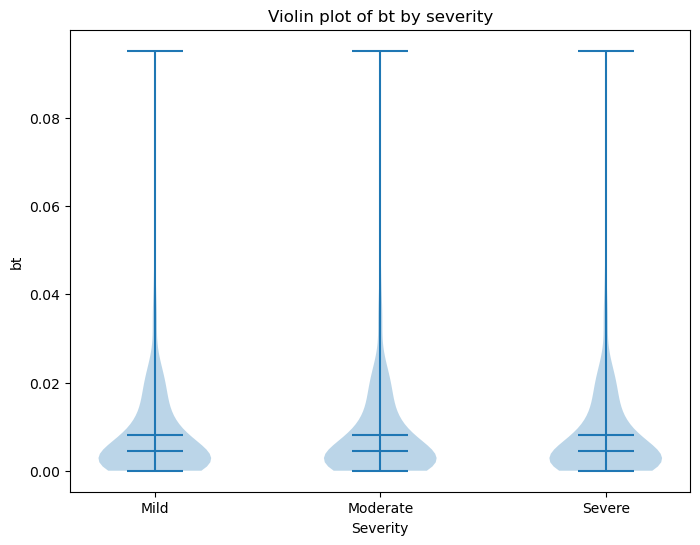

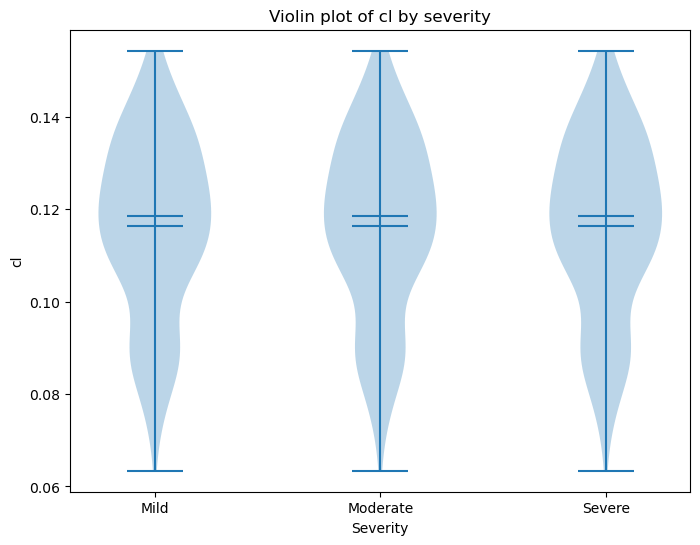

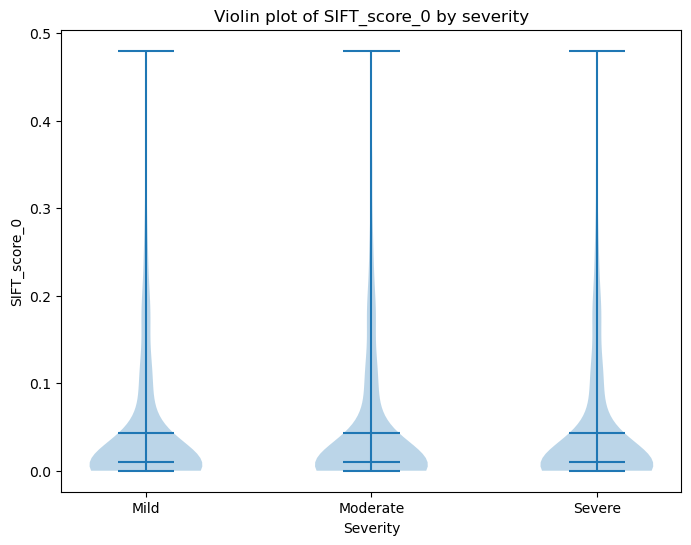

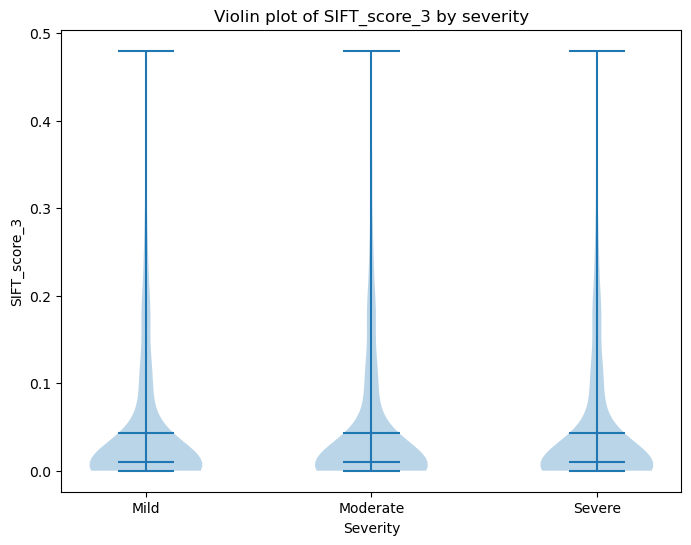

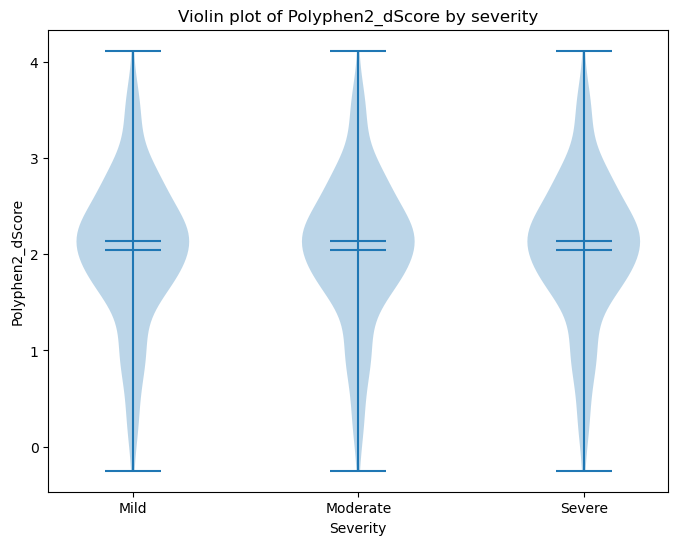

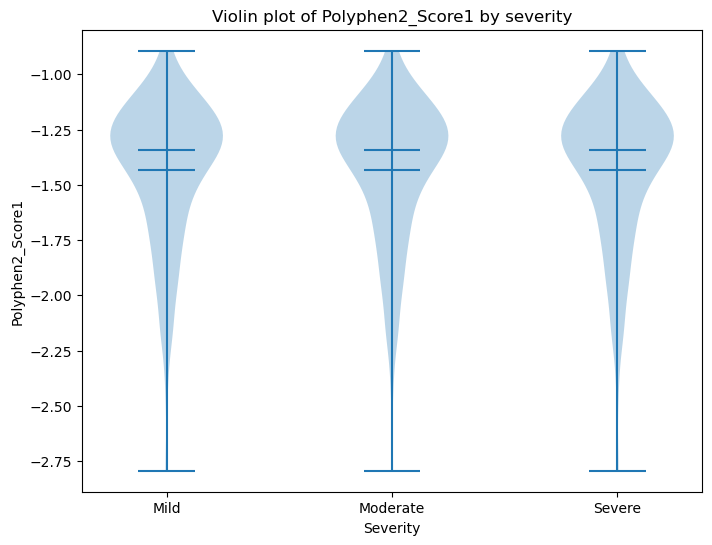

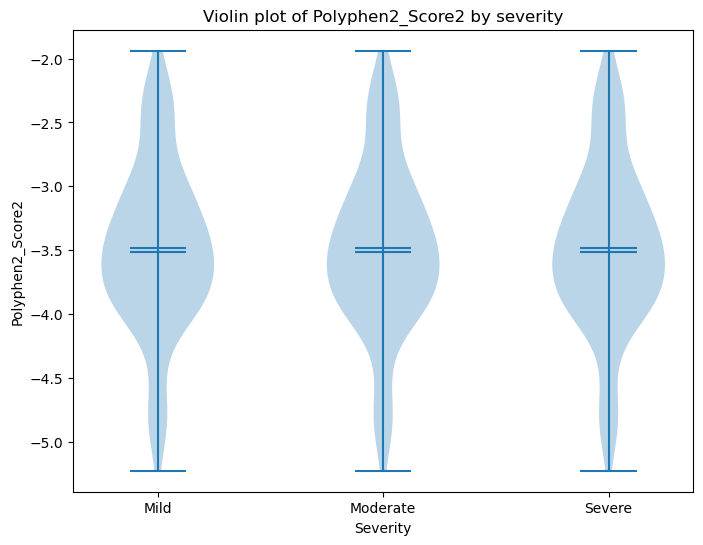

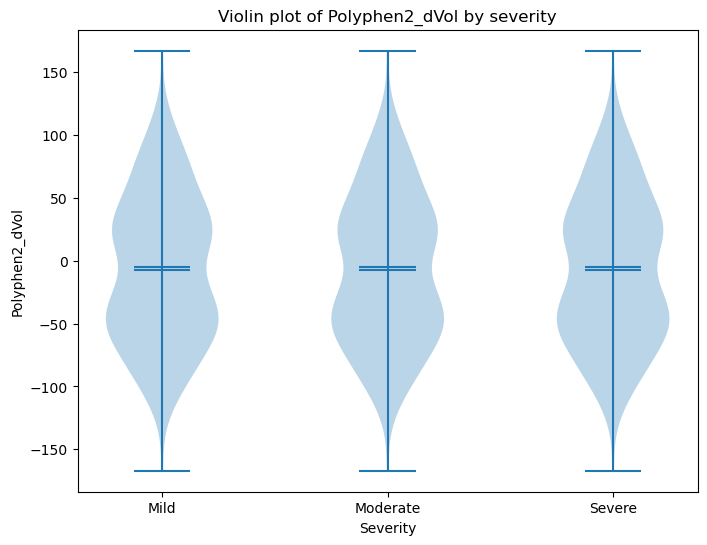

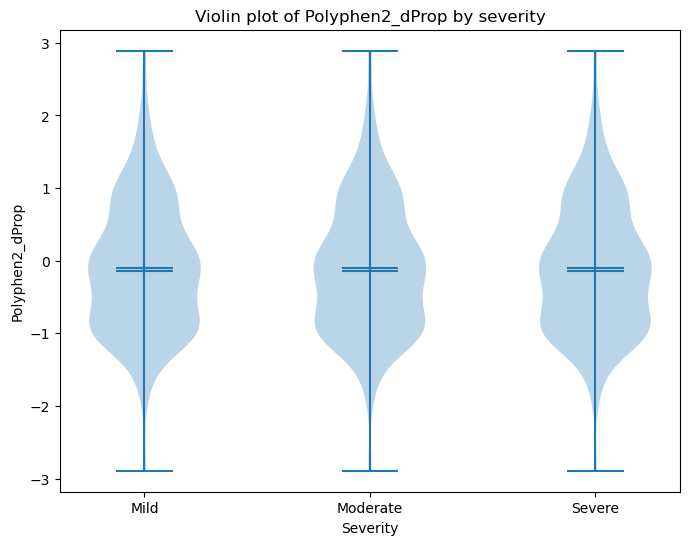

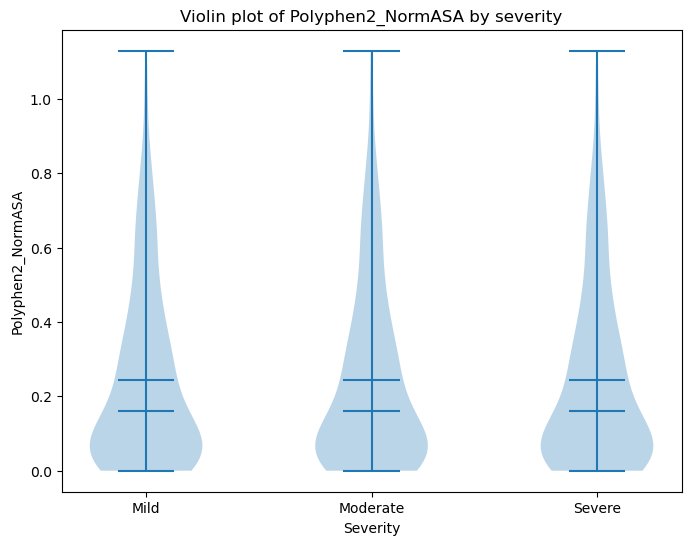

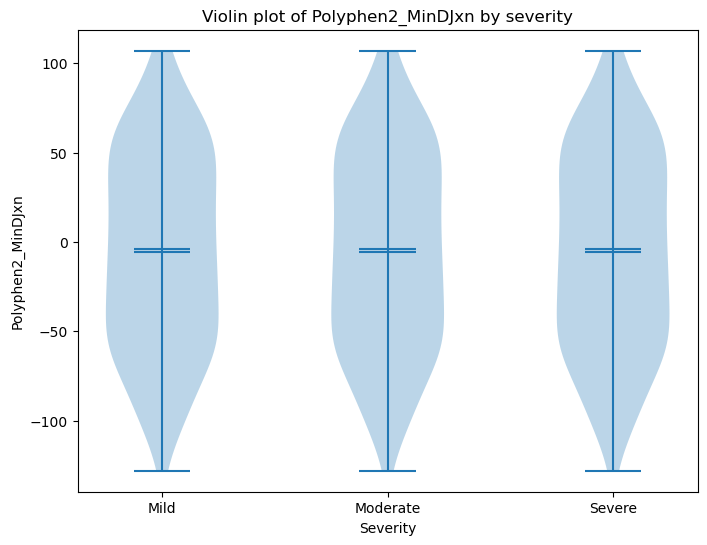

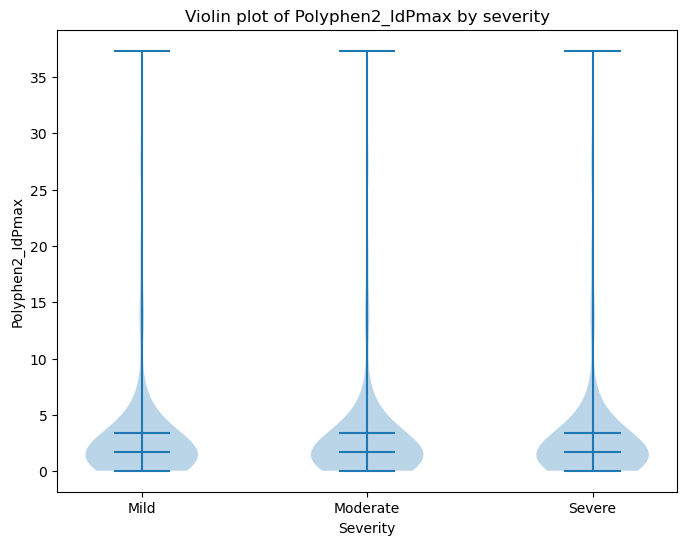

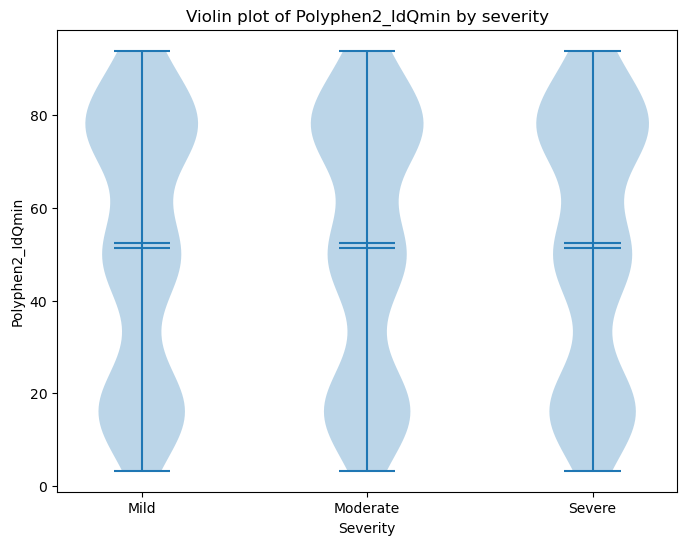

In [139]:
patients_data_V3_melted = pd.melt(patients_data_v3, 
                                  id_vars=['AA_HGVS', 'domain', 
                                           'discrepancy', 'relSESA', 
                                           'consurf_old', 'dg', 'bt', 'cl', 
                                           'auth', 'kcore', 'WT_aa', 'new_aa', 
                                           'SIFT_score_0', 'SIFT_score_3', 'Polyphen2_dScore', 
                                           'Polyphen2_Score1', 'Polyphen2_Score2', 
                                           'Polyphen2_dVol', 'Polyphen2_dProp', 'Polyphen2_NormASA', 
                                           'Polyphen2_MinDJxn', 'Polyphen2_IdPmax',
                                             'Polyphen2_IdQmin'], var_name='severity', value_name='severity_value')

grouped = patients_data_V3_melted.groupby('severity')

for col in col_name_list:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.violinplot([group[col].dropna() for name, group in grouped], showmeans=True, showmedians=True)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Mild', 'Moderate', 'Severe'])
    ax.set_xlabel('Severity')
    ax.set_ylabel(col)
    ax.set_title(f'Violin plot of {col} by severity')
    plt.show()

## Splitting the columns into dependent and independent variables 

In [ ]:
X = patients_data_v3.drop("discrepancy", axis = 1).copy()
X.head()

In [ ]:
patients_data_v3['discrepancy'] = patients_data_v3['discrepancy'].replace({'Yes': 1, 'No': 0})

y = patients_data_v3["discrepancy"].copy()
y.head()

In [ ]:
y.unique()

## Creating one hot encoding

In [ ]:
# Create an empty array to store the column names
obj_columns = []

# Loop through the columns of the dataframe
for col in X.columns:
    # Check if the column is an object
    if X[col].dtype == "object":
        # Save the column name to the array
        obj_columns.append(col)

# Print the array
print(obj_columns)

In [ ]:
X_encoded = pd.get_dummies(X, columns= obj_columns)
X_encoded.head()

## Preliminary XGBOOST MODEL

In [ ]:
sum(y)/len(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify= y)

In [ ]:
sum(y_train)/len(y_train)

In [ ]:
sum(y_test) / len(y_test) 

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [ ]:

xgb_model = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "auc", random_state = 42, n_estimators=200, max_depth=5, learning_rate=0.1)

xgb_model.fit(X_train_smote, y_train_smote)

y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plot_confusion_matrix(xgb_model, X_test, y_test, cmap = "Blues")

## Fine Tuning the model 

In [ ]:

params = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3)
}

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

xgb_search.fit(X_train, y_train)

print("Best parameters:", xgb_search.best_params_)
print("Best AUC score:", xgb_search.best_score_)

xgb_tuned = xgb_search.best_estimator_

y_pred_tuned = xgb_tuned.predict(X_test)

cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print("Confusion Matrix:\n", cm_tuned)

plot_confusion_matrix(xgb_tuned, X_test, y_test, cmap = "Blues")


In [ ]:
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print("XGBoost Balanced Accuracy Score:", bal_acc_xgb)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_model, ax=ax)
plt.show()

## Creating a logistic regression model

In [ ]:
lr_model = LogisticRegression(random_state=42)

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Predict the test set labels using the fitted model
y_pred_lr = lr_model.predict(X_test)

# Calculate and print the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

# Calculate the balanced accuracy score and print it
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Balanced Accuracy Score:", bal_acc_lr)